# Проект по курсу Разведочный анализ данных

## Дешевые маршруты
Цель:
- Для удобства выберите 15 или больше городов Европы. Можно и не Европы, главное
чтобы были перелеты.
- Спарсите цены за какой-то определенный день с [aviasales](https://www.aviasales.ru)
или [skyscanner](https://www.skyscanner.ru).
- Создайте граф, где вершина это город, ребро это перелет, а вес ребра это цена.
- Пример модели: knn
- Пример алгоритма: создание графа + с помощью алгоритма Дейкстры найти самые
дешевые маршруты. Для создания графов можно использовать pgraph
(https://pypi.org/project/pgraph-python/)

# 1 Этап I
1.1 Реализация парсера.
<br>1.2 Особенности выборки по результатам первичного анализа,
удаление выбросов/пропусков
    <br>1.2.1 Особенности выборки внутренних рейсов
    <br>1.2.2 Особенности выборки международных рейсов
<br> 1.3 Интересные моменты в данных
    <br>1.3.1 Динамика стоимости перелетов внутри России в течение года
    <br>1.3.2 Динамика стоимости международных перелетов из России в течение 
<br> 1.4 Моменты, которые позволяют до проведения расчетов и
построения моделей, выдвинуть несколько гипотез/предположений о
результатах следующих этапов и т.д.

## 1.1 Реализация парсера

In [3]:
import requests
import time
import numpy as np
import pandas as pd
import datetime
import json

**Выберем произвольно 12 городов России и 3 зарубежных города:**

In [4]:
directions = pd.DataFrame({'Cites': ['Moskow', 'Krasnoyarsk', 'Saint_Petersburg', 'Barnayl', 'Astrakhan', 'Kazan', 'Kaliningrad', 'Abakan', 'Voronezh', 'Yuzhn_Sakhalinsk', 'Ekaterinburg', 'Krasnodar', 'Antalia', 'Vena', 'Dubai'],
                      'ИАТА': ['MOW','KJA','LED', 'BAX', 'ASF', 'KZN', 'KGD','ABA', 'VOZ', 'UUS', 'SVX', 'KRR', 'AYT', 'VIE','DXB'],
                      'latitude': ['55.973300111167156', '56.1768415087914', '59.80043766638254', '53.36349016330523', '46.2869335064941', '55.60834333108408', '54.769303646029876', '53.749703793034485', '51.8131151906088', '46.8847368833394', '56.748654478747135', '45.033773929532714', '36.91233469430595', '48.11551950274862', '25.25230190216661'],
                      'longitude': ['37.412626915851845', '92.48103489205155', '30.26616314019766', '83.55055165906884', '47.9999978766347', '49.28178864698746', '20.407785703085974', '91.39727647266704', '39.22629757821067', '142.72161741108812', '60.801605541490964', '39.14046019424804', '30.79956426931853' , '16.570312472879277', '55.3634453360487']})
directions

,Cites,ИАТА,latitude,longitude
0,Moskow,MOW,55.973300111167156,37.412626915851845
1,Krasnoyarsk,KJA,56.1768415087914,92.48103489205155
2,Saint_Petersburg,LED,59.80043766638254,30.26616314019766
3,Barnayl,BAX,53.36349016330523,83.55055165906884
4,Astrakhan,ASF,46.2869335064941,47.9999978766347
5,Kazan,KZN,55.60834333108408,49.28178864698746
6,Kaliningrad,KGD,54.769303646029876,20.407785703085974
7,Abakan,ABA,53.749703793034485,91.39727647266704
8,Voronezh,VOZ,51.8131151906088,39.22629757821067
9,Yuzhn_Sakhalinsk,UUS,46.8847368833394,142.72161741108812


**Визуализируем на карте место положения выбранных городов:**

In [5]:
import folium

In [6]:
lat = directions['latitude'] 
lon = directions['longitude']
cityName = directions['Cites']

In [7]:
map = folium.Map(location=[55.54, 87.22], zoom_start = 2.3)

for lat, lon, cityName in zip(lat, lon, cityName):
    folium.Marker(location=[lat, lon], popup=str(cityName), icon=folium.Icon(colour = 'blue')).add_to(map)
map

**Реализуем сбор данных о перелетах на 2022 и конец 2021 года по всем возможным комбинациям исследуемых направлений при помощи API Aviasales:**

In [8]:
def dai_zeny(origin, destination):
    z = []
    k = 0
    m = 0
    l = 1
    response = requests.get("http://api.travelpayouts.com/v2/prices/latest", params = {'origin': origin, 'destination' : destination, 'one_way':True, 'period_type':'year', 'limit': '999', 'sorting': 'price', 'token':'dd73820d3d296e41bee44519be48ef75'})
    if not response.ok:
        print('Server responded:', response.status_code)
    else:
        infa = response.json()
    return infa

In [9]:
def koks (origin):
    cities = ['KJA','MOW','LED', 'BAX', 'ASF', 'KZN', 'KGD','ABA', 'VOZ', 'UUS', 'SVX', 'KRR', 'AYT', 'VIE','DXB' ]
    dep_cities = []
    for i in cities:
        if i == origin:
            cities.remove(i)
    for i in cities:
        zena = dai_zeny(origin,i)
        dep_cities.append(zena)
    return dep_cities


In [10]:
# Построим списки. На каждый город из списка получаем комбинацию перелетов из оставшися исследуемых городов.
list_dates_1 = koks('MOW')
list_dates_2 = koks('KJA')
list_dates_3 = koks('LED')
list_dates_4 = koks('BAX')
list_dates_5 = koks('ASF')
list_dates_6 = koks('KZN')
list_dates_7 = koks('KGD')
list_dates_8 = koks('ABA')
list_dates_9 = koks('VOZ')
list_dates_10 = koks('UUS')
list_dates_11 = koks('SVX')
list_dates_12 = koks('KRR')
list_dates_13 = koks('AYT')
list_dates_14 = koks('VIE')
list_dates_15 = koks('DXB')

**Получим датасеты с перелетами из указанных городов в остальные исследуемые:**

In [165]:
#Для Москвы:
mow = pd.DataFrame()
for i in range(0,14,1):
    df = pd.DataFrame(list_dates_1[i]['data'])   
    df = df.drop(['trip_class', 'show_to_affiliates', 'gate', 'return_date', 'found_at', 'actual'], axis=1)
    mow = pd.concat([mow,df], axis=0,ignore_index=True)
# mow

In [166]:
#Для Красноярска:
krs = pd.DataFrame()
for i in range(0,14,1):
    df = pd.DataFrame(list_dates_2[i]['data'])
    df = df.drop(['trip_class', 'show_to_affiliates', 'gate', 'return_date', 'found_at', 'actual'], axis=1)
    krs = pd.concat([krs,df], axis=0,ignore_index=True)
#krs

In [167]:
#Для Санкт-Питербурга:
spb = pd.DataFrame()
for i in range(0,14,1):
    df = pd.DataFrame(list_dates_3[i]['data'])
    df = df.drop(['trip_class', 'show_to_affiliates', 'gate', 'return_date', 'found_at', 'actual'], axis=1)
    spb = pd.concat([spb,df], axis=0,ignore_index=True)
#spb

In [168]:
#Для Барнаула:
bax = pd.DataFrame()
for i in range(0,14,1):
    df = pd.DataFrame(list_dates_4[i]['data'])
    df = df.drop(['trip_class', 'show_to_affiliates', 'gate', 'return_date', 'found_at', 'actual'], axis=1)
    bax = pd.concat([bax,df], axis=0,ignore_index=True)
#bax

In [169]:
#Для Астрахани:
asf = pd.DataFrame()
for i in range(0,14,1):
    df = pd.DataFrame(list_dates_5[i]['data'])
#|    df = df.drop('gate', axis=1)
    asf = pd.concat([asf,df], axis=0,ignore_index=True)
asf = asf.drop(['trip_class', 'show_to_affiliates', 'gate', 'return_date', 'found_at', 'actual'], axis=1)
#asf

In [170]:
#Для Казани
kzn = pd.DataFrame()
for i in range(0,14,1):
    df = pd.DataFrame(list_dates_6[i]['data'])
    df = df.drop(['trip_class', 'show_to_affiliates', 'gate', 'return_date', 'found_at', 'actual'], axis=1)
    kzn = pd.concat([kzn,df], axis=0,ignore_index=True)
#kzn

In [171]:
#Для Калининграда
kgd = pd.DataFrame()
for i in range(0,14,1):
    df = pd.DataFrame(list_dates_7[i]['data'])
    df = df.drop(['trip_class', 'show_to_affiliates', 'gate', 'return_date', 'found_at', 'actual'], axis=1)
    kgd = pd.concat([kgd,df], axis=0,ignore_index=True)
#kgd

In [172]:
#Для Абакана
aba = pd.DataFrame()
for i in range(0,14,1):
    df = pd.DataFrame(list_dates_8[i]['data'])
    df = df.drop(['trip_class', 'show_to_affiliates', 'gate', 'return_date', 'found_at', 'actual'], axis=1)
    aba = pd.concat([aba,df], axis=0,ignore_index=True)
#aba

In [173]:
#Для Воронежа
voz = pd.DataFrame()
for i in range(0,14,1):
    df = pd.DataFrame(list_dates_9[i]['data'])
    df = df.drop(['trip_class', 'show_to_affiliates', 'gate', 'return_date', 'found_at', 'actual'], axis=1)
    voz = pd.concat([voz,df], axis=0,ignore_index=True)
#voz

In [174]:
#Для Южно-Сахалинска:
uus = pd.DataFrame()
for i in range(0,14,1):
    df = pd.DataFrame(list_dates_10[i]['data'])
    uus = pd.concat([uus,df], axis=0,ignore_index=True)
uus = df.drop(['trip_class', 'show_to_affiliates', 'gate', 'return_date', 'found_at', 'actual'], axis=1)
#uus

In [175]:
#Для Екатеринбурга:
svx = pd.DataFrame()
for i in range(0,14,1):
    df = pd.DataFrame(list_dates_11[i]['data'])
    df = df.drop(['trip_class', 'show_to_affiliates', 'gate', 'return_date', 'found_at', 'actual'], axis=1)
    svx = pd.concat([svx,df], axis=0,ignore_index=True)
#svx

In [176]:
#Для Краснодара:
krr = pd.DataFrame()
for i in range(0,14,1):
    df = pd.DataFrame(list_dates_12[i]['data'])
    df = df.drop(['trip_class', 'show_to_affiliates', 'gate', 'return_date', 'found_at', 'actual'], axis=1)
    krr = pd.concat([krr,df], axis=0,ignore_index=True)
#krr

In [177]:
#Для Антальи:
ayt = pd.DataFrame()
for i in range(0,14,1):
    df = pd.DataFrame(list_dates_13[i]['data'])
    df = df.drop(['trip_class', 'show_to_affiliates', 'gate', 'return_date', 'found_at', 'actual'], axis=1)
    ayt = pd.concat([ayt,df], axis=0,ignore_index=True)
#ayt

In [178]:
#Для Вены:
vie = pd.DataFrame()
for i in range(0,14,1):
    df = pd.DataFrame(list_dates_14[i]['data'])
    df = df.drop(['trip_class', 'show_to_affiliates', 'gate', 'return_date', 'found_at', 'actual'], axis=1)
    vie = pd.concat([vie,df], axis=0,ignore_index=True)
#vie

In [179]:
#Для Дубая:
dxb = pd.DataFrame()
for i in range(0,14,1):
    df = pd.DataFrame(list_dates_15[i]['data'])
    df = df.drop(['trip_class', 'show_to_affiliates', 'gate', 'return_date', 'found_at', 'actual'], axis=1)
    dxb = pd.concat([dxb,df], axis=0,ignore_index=True)
#dxb

**Cформируем единый датасет:**

In [180]:
big_data = pd.concat([krs, mow, spb, bax, asf, kzn, kgd, aba, voz, uus, svx, krr, ayt, vie, dxb], axis=0, ignore_index=True)
big_data

,value,origin,destination,depart_date,number_of_changes,duration,distance
0,3485,KJA,MOW,2022-01-30,0,300,3348
1,3485,KJA,MOW,2022-01-29,0,300,3348
2,3485,KJA,MOW,2022-02-19,0,300,3348
3,3485,KJA,MOW,2022-01-23,0,300,3348
4,3485,KJA,MOW,2022-03-13,0,300,3348
...,...,...,...,...,...,...,...
33696,31003,DXB,VIE,2021-12-22,1,1330,4223
33697,31109,DXB,VIE,2022-01-15,1,1050,4223
33698,36479,DXB,VIE,2021-12-31,1,1640,4223
33699,36514,DXB,VIE,2022-01-16,1,665,4223


<br>**value** — цена билета.
<br>**origin** — IATA-код города вылета.
<br>**destination** — IATA-код города назначения.
<br>**depart_date** — дата вылета.
<br>**number_of_changes** — количество пересадок.
<br>**duration** — продолжительность перелета (мин.).
<br>**distance** — дальность перелета в (км).

In [209]:
#Сохраним полученный датафрэйм в файл csv:
big_data.to_csv('big_data.csv', index=False)

## 1.2 Особенности выборки по результатам первичного анализа, удаление выбросов/пропусков.

In [212]:
#Откроем ранее сохраненный 'big_data.csv':
big_data = pd.read_csv('big_data.csv', index_col=0)

In [213]:
big_data

,value,origin,destination,depart_date,number_of_changes,duration,distance
Unnamed: 0,,,,,,,
0,3485,KJA,MOW,2022-01-30,0,300,3348
1,3485,KJA,MOW,2022-01-29,0,300,3348
2,3485,KJA,MOW,2022-02-19,0,300,3348
3,3485,KJA,MOW,2022-01-23,0,300,3348
4,3485,KJA,MOW,2022-03-13,0,300,3348
...,...,...,...,...,...,...,...
33696,31003,DXB,VIE,2021-12-22,1,1330,4223
33697,31109,DXB,VIE,2022-01-15,1,1050,4223
33698,36479,DXB,VIE,2021-12-31,1,1640,4223


In [214]:
#Создадим и добавим к данным новый столбец с отправлениями в указанных месяцах.
big_data['depart_date']
big_data['depart_month'] = big_data['depart_date']

In [215]:
big_data['depart_month'] = big_data['depart_month'].map(lambda x: str(x)[:-3])
big_data

,value,origin,destination,depart_date,number_of_changes,duration,distance,depart_month
Unnamed: 0,,,,,,,,
0,3485,KJA,MOW,2022-01-30,0,300,3348,2022-01
1,3485,KJA,MOW,2022-01-29,0,300,3348,2022-01
2,3485,KJA,MOW,2022-02-19,0,300,3348,2022-02
3,3485,KJA,MOW,2022-01-23,0,300,3348,2022-01
4,3485,KJA,MOW,2022-03-13,0,300,3348,2022-03
...,...,...,...,...,...,...,...,...
33696,31003,DXB,VIE,2021-12-22,1,1330,4223,2021-12
33697,31109,DXB,VIE,2022-01-15,1,1050,4223,2022-01
33698,36479,DXB,VIE,2021-12-31,1,1640,4223,2021-12


**Данные 'хорошие', пустых строк не выявлено.**

In [216]:
# Оценим уникальные значения колонки [depart_month]
big_data = big_data.sort_values(by='depart_month')
big_data['depart_month'].unique()

array(['2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05',
       '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11',
       '2022-12'], dtype=object)

In [217]:
#Создадим и добавим к данным новый столбец ['distance_unit_price'] - цена за 1 километр.
big_data['value']
big_data['distance']
big_data['distance_unit_price'] = big_data['value'] / big_data['distance']
big_data

,value,origin,destination,depart_date,number_of_changes,duration,distance,depart_month,distance_unit_price
Unnamed: 0,,,,,,,,,
1901,8467,KJA,SVX,2021-12-31,1,1255,1929,2021-12,4.389321
25619,10000,SVX,KGD,2021-12-29,0,310,2484,2021-12,4.025765
25616,9438,SVX,KGD,2021-12-28,1,355,2484,2021-12,3.799517
25604,8543,SVX,KGD,2021-12-27,1,770,2484,2021-12,3.439211
25493,6948,SVX,KGD,2021-12-25,1,845,2484,2021-12,2.797101
...,...,...,...,...,...,...,...,...,...
27549,3250,KRR,MOW,2022-12-08,0,135,1157,2022-12,2.808989
33186,30940,DXB,KZN,2022-12-13,2,800,3411,2022-12,9.070654
27547,3250,KRR,MOW,2022-12-13,0,135,1157,2022-12,2.808989


**Полученные значения говорят о том что данные полностью соответствуют 2022 году и концу 2021.**

### 1.2.1 Особенности выборки внутренних рейсов
<br> Оценим основную статистику стоимости перелета из городов России в Москву в течение года. Поработаем с выбросами:


Красноярск - Москва:

In [218]:
#Красноярск-Москва
kja_mow = big_data[big_data['origin'].str.contains(r'KJA')]
kja_mow = kja_mow[kja_mow['destination'].str.contains(r'MOW')]
kja_mow = kja_mow.sort_values(by='depart_date')       

#Красноярск-Москва(фрэйм без удаления выбросов)
kja_mowSravn = big_data[big_data['origin'].str.contains(r'KJA')]
kja_mowSravn = kja_mow[kja_mow['destination'].str.contains(r'MOW')]
kja_mowSravn = kja_mow.sort_values(by='depart_date')

In [219]:
kja_mow.describe()

,value,number_of_changes,duration,distance,distance_unit_price
count,333.000000,333.000000,333.000000,333.000000,333.000000
mean,5315.870871,0.015015,328.318318,3337.837838,1.592848
std,2140.909868,0.121795,240.712473,12.033493,0.643171
min,3485.000000,0.000000,295.000000,3322.000000,1.040920
25%,3862.000000,0.000000,295.000000,3324.000000,1.161853
50%,4655.000000,0.000000,305.000000,3348.000000,1.390382
75%,6655.000000,0.000000,305.000000,3348.000000,1.987754
max,26204.000000,1.000000,3180.000000,3348.000000,7.883273


In [220]:
#Оценим статистику выборочных данных:
print ('Средняя стоимость билета Красноярск - Москва: ', kja_mow['value'].mean())
print ('Медиана стоимости билета Красноярск - Москва: ', kja_mow['value'].median())
print ('Стандартное отклонение стоимости билета Красноярск - Москва: ', kja_mow['value'].std())
print ('Максимальная стоимость билета Красноярск - Москва: ', kja_mow['value'].max())

Средняя стоимость билета Красноярск - Москва:  5315.870870870871
Медиана стоимости билета Красноярск - Москва:  4655.0
Стандартное отклонение стоимости билета Красноярск - Москва:  2140.9098683972547
Максимальная стоимость билета Красноярск - Москва:  26204


<AxesSubplot:ylabel='Frequency'>

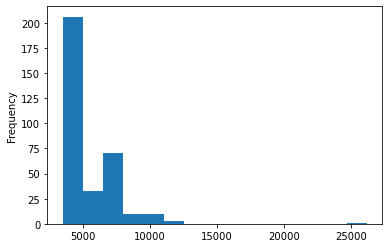

In [221]:
kja_mow['value'].plot(kind='hist', bins=15)

По предварительнй статистической оценки можем наблюдать выброс(ы) со значением(ями) далеким(и) от среднего значения стоимости билета.
<br>   Обнаружим выброс при помощи IQR - подхода:

In [222]:
#kja_mow.sort_values(by='value')

<AxesSubplot:>

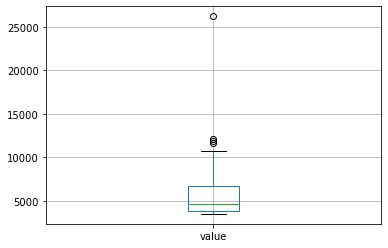

In [223]:
#Рассмотрим выброс по ближе, применим коробчатую диаграмму:
kja_mow.boxplot('value')

Можем оценить выбросы, которые лежат над верхней границей

Проведем работу по удалению выбросов:
<br> 1. Рассчитаем первый и третий квартиль.
<br> 2. Найдем межквартильный диапазон.
<br> 3. Установим нижнюю и верхнюю границу.
<br> 4. Заменим значения которые лежат выше и ниже установленной гранцицы на нулевые значения.

In [224]:
for i in ['value']:
    q75,q25 = np.percentile(kja_mow.loc[:,i],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    kja_mow.loc[kja_mow[i] < min,i] = np.nan
    kja_mow.loc[kja_mow[i] > max,i] = np.nan

In [225]:
#Определим сколько значений вышло за фиксированный диапазон.
kja_mow.isnull().sum()

value                  4
origin                 0
destination            0
depart_date            0
number_of_changes      0
duration               0
distance               0
depart_month           0
distance_unit_price    0
dtype: int64

In [226]:
#Удалим строки с нулевыми значениями.
kja_mow = kja_mow.dropna(axis = 0)

Представим, как изменится распределение данных после удаления выбросов.

<AxesSubplot:ylabel='Frequency'>

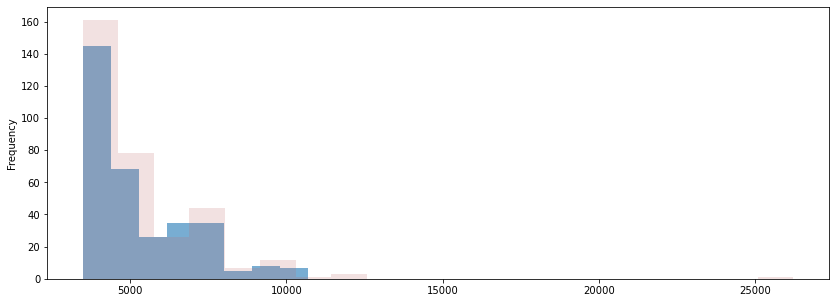

In [227]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 5)) 

kja_mow['value'].plot(kind='hist', bins=8, alpha = .6)
kja_mowSravn['value'].plot(kind='hist', bins=20, alpha = .2, color = sns.desaturate("indianred", .75))

Красным цветом показано распределение данных до даления выбросов. Визуально можно подтвердить, что основные выбросы из набора данных удалены.

In [228]:
#Оценим статистику выборочных данных:
print ('Средняя стоимость билета Красноярск - Москва до удаления выбросов: %4.2f'% kja_mow['value'].mean(), ', после: %4.2f'% kja_mowSravn['value'].mean()) 

Средняя стоимость билета Красноярск - Москва до удаления выбросов: 5192.76 , после: 5315.87


In [229]:
#Т.к для одного направления существуют 3 уникальных значения расстояния, заменим их на одно фиксированное среднее.
kja_mow['distance'].unique()

array([3348, 3322, 3324], dtype=int64)

In [230]:
kja_mowMean = int(kja_mow['distance'].mean())
kja_mow.loc[kja_mow['distance'] > 0, 'distance'] = kja_mowMean

In [231]:
kja_mow

,value,origin,destination,depart_date,number_of_changes,duration,distance,depart_month,distance_unit_price
Unnamed: 0,,,,,,,,,
313,8796.0,KJA,MOW,2021-12-22,1,2605,3337,2021-12,2.627240
327,10199.0,KJA,MOW,2021-12-23,1,505,3337,2021-12,3.070138
321,9752.0,KJA,MOW,2021-12-24,1,2605,3337,2021-12,2.912784
319,9565.0,KJA,MOW,2021-12-25,0,310,3337,2021-12,2.879290
241,6599.0,KJA,MOW,2021-12-26,0,320,3337,2021-12,1.971027
...,...,...,...,...,...,...,...,...,...
293,7551.0,KJA,MOW,2022-12-06,0,305,3337,2022-12,2.273028
288,7551.0,KJA,MOW,2022-12-12,0,310,3337,2022-12,2.273028
286,7551.0,KJA,MOW,2022-12-13,0,305,3337,2022-12,2.273028


**Проведем аналогичную работу с ругими городами:**

In [232]:
#Санкт-Питербург-Москва
spb_mow = big_data[big_data['origin'].str.contains(r'LED')]
spb_mow = spb_mow[spb_mow['destination'].str.contains(r'MOW')]
spb_mow = spb_mow.sort_values(by='depart_date')
#spb_mow

In [233]:
for i in ['value']:
    q75,q25 = np.percentile(spb_mow.loc[:,i],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    spb_mow.loc[spb_mow[i] < min,i] = np.nan
    spb_mow.loc[spb_mow[i] > max,i] = np.nan

In [234]:
#Удалим строки с нулевыми значениями.
spb_mow = spb_mow.dropna(axis = 0)

In [235]:
#Заменим Расстояние между Аэропортами на среднее значеие из столбца:
spb_mowMean = int(spb_mow['distance'].mean())
spb_mow.loc[spb_mow['distance'] > 0, 'distance'] = spb_mowMean

In [236]:
#Барнаул-Москва
bax_mow = big_data[big_data['origin'].str.contains(r'BAX')]
bax_mow = bax_mow[bax_mow['destination'].str.contains(r'MOW')]
bax_mow = bax_mow.sort_values(by='depart_date')
#bax_mow

In [237]:
for i in ['value']:
    q75,q25 = np.percentile(bax_mow.loc[:,i],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    bax_mow.loc[bax_mow[i] < min,i] = np.nan
    bax_mow.loc[bax_mow[i] > max,i] = np.nan

In [238]:
#Удалим строки с нулевыми значениями.
bax_mow = bax_mow.dropna(axis = 0)

In [239]:
#Заменим Расстояние между Аэропортами на среднее значеие из столбца:
bax_mowMean = int(bax_mow['distance'].mean())
bax_mow.loc[bax_mow['distance'] > 0, 'distance'] = bax_mowMean

In [240]:
#Астрахань-Москва
asf_mow = big_data[big_data['origin'].str.contains(r'ASF')]
asf_mow = asf_mow[asf_mow['destination'].str.contains(r'MOW')]
asf_mow = asf_mow.sort_values(by='depart_date')
#asf_mow

In [241]:
for i in ['value']:
    q75,q25 = np.percentile(asf_mow.loc[:,i],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    asf_mow.loc[asf_mow[i] < min,i] = np.nan
    asf_mow.loc[asf_mow[i] > max,i] = np.nan

In [242]:
#Удалим строки с нулевыми значениями.
asf_mow = asf_mow.dropna(axis = 0)

In [243]:
#Заменим Расстояние между Аэропортами на среднее значеие из столбца:
asf_mowMean = int(asf_mow['distance'].mean())
asf_mow.loc[asf_mow['distance'] > 0, 'distance'] = asf_mowMean

In [244]:
#Казань-Москва
kzn_mow = big_data[big_data['origin'].str.contains(r'KZN')]
kzn_mow = kzn_mow[kzn_mow['destination'].str.contains(r'MOW')]
kzn_mow = kzn_mow.sort_values(by='depart_date')
#kzn_mow

In [245]:
for i in ['value']:
    q75,q25 = np.percentile(kzn_mow.loc[:,i],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    kzn_mow.loc[kzn_mow[i] < min,i] = np.nan
    kzn_mow.loc[kzn_mow[i] > max,i] = np.nan

In [246]:
#Удалим строки с нулевыми значениями.
kzn_mow = kzn_mow.dropna(axis = 0)

In [247]:
#Заменим Расстояние между Аэропортами на среднее значеие из столбца:
kzn_mowMean = int(kzn_mow['distance'].mean())
kzn_mow.loc[kzn_mow['distance'] > 0, 'distance'] = kzn_mowMean

In [248]:
#Калининград-Москва
kgd_mow = big_data[big_data['origin'].str.contains(r'KGD')]
kgd_mow = kgd_mow[kgd_mow['destination'].str.contains(r'MOW')]
kgd_mow = kgd_mow.sort_values(by='depart_date')
#kgd_mow

In [249]:
for i in ['value']:
    q75,q25 = np.percentile(kgd_mow.loc[:,i],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    kgd_mow.loc[kgd_mow[i] < min,i] = np.nan
    kgd_mow.loc[kgd_mow[i] > max,i] = np.nan

In [250]:
#Удалим строки с нулевыми значениями.
kgd_mow = kgd_mow.dropna(axis = 0)

In [251]:
#Заменим Расстояние между Аэропортами на среднее значеие из столбца:
kgd_mowMean = int(kgd_mow['distance'].mean())
kgd_mow.loc[kgd_mow['distance'] > 0, 'distance'] = kgd_mowMean

In [252]:
#Воронеж-Москва
voz_mow = big_data[big_data['origin'].str.contains(r'VOZ')]
voz_mow = voz_mow[voz_mow['destination'].str.contains(r'MOW')]
voz_mow = voz_mow.sort_values(by='depart_date')
#voz_mow

In [253]:
for i in ['value']:
    q75,q25 = np.percentile(voz_mow.loc[:,i],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    voz_mow.loc[voz_mow[i] < min,i] = np.nan
    voz_mow.loc[voz_mow[i] > max,i] = np.nan

In [254]:
#Удалим строки с нулевыми значениями.
voz_mow = voz_mow.dropna(axis = 0)

In [255]:
#Заменим Расстояние между Аэропортами на среднее значеие из столбца:
voz_mowMean = int(voz_mow['distance'].mean())
voz_mow.loc[voz_mow['distance'] > 0, 'distance'] = voz_mowMean

In [256]:
#Екатеринбург-Москва
svx_mow = big_data[big_data['origin'].str.contains(r'SVX')]
svx_mow = svx_mow[svx_mow['destination'].str.contains(r'MOW')]
svx_mow = svx_mow.sort_values(by='depart_date')
#svx_mow

In [257]:
for i in ['value']:
    q75,q25 = np.percentile(svx_mow.loc[:,i],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    svx_mow.loc[svx_mow[i] < min,i] = np.nan
    svx_mow.loc[svx_mow[i] > max,i] = np.nan

In [258]:
#Удалим строки с нулевыми значениями.
svx_mow = svx_mow.dropna(axis = 0)

In [259]:
#Заменим Расстояние между Аэропортами на среднее значеие из столбца:
svx_mowMean = int(svx_mow['distance'].mean())
svx_mow.loc[svx_mow['distance'] > 0, 'distance'] = svx_mowMean

In [260]:
#Краснодар-Москва
krr_mow = big_data[big_data['origin'].str.contains(r'KRR')]
krr_mow = krr_mow[krr_mow['destination'].str.contains(r'MOW')]
krr_mow = krr_mow.sort_values(by='depart_date')
#krr_mow

In [261]:
for i in ['value']:
    q75,q25 = np.percentile(krr_mow.loc[:,i],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    krr_mow.loc[krr_mow[i] < min,i] = np.nan
    krr_mow.loc[krr_mow[i] > max,i] = np.nan

In [262]:
#Удалим строки с нулевыми значениями.
krr_mow = krr_mow.dropna(axis = 0)

In [263]:
#Заменим Расстояние между Аэропортами на среднее значеие из столбца:
krr_mowMean = int(krr_mow['distance'].mean())
krr_mow.loc[krr_mow['distance'] > 0, 'distance'] = krr_mowMean

### 1.2.2 Особенности выборки международных рейсов
<br> Проведем работу с выбросами стоимости перелета из Москвы в зарубежные города в течение года:

In [264]:
#Москва-Анталья
mow_ayt = big_data[big_data['origin'].str.contains(r'MOW')]
mow_ayt = mow_ayt[mow_ayt['destination'].str.contains(r'AYT')]
mow_ayt = mow_ayt.sort_values(by='depart_date')
#mow_ayt

In [265]:
for i in ['value']:
    q75,q25 = np.percentile(mow_ayt.loc[:,i],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    mow_ayt.loc[mow_ayt[i] < min,i] = np.nan
    mow_ayt.loc[mow_ayt[i] > max,i] = np.nan

In [266]:
#Удалим строки с нулевыми значениями.
mow_ayt = mow_ayt.dropna(axis = 0)

In [267]:
#Заменим Расстояние между Аэропортами на среднее значеие из столбца:
mow_aytMean = int(mow_ayt['distance'].mean())
mow_ayt.loc[mow_ayt['distance'] > 0, 'distance'] = mow_aytMean

In [268]:
#Москва-Вена
mow_vie = big_data[big_data['origin'].str.contains(r'MOW')]
mow_vie = mow_vie[mow_vie['destination'].str.contains(r'VIE')]
mow_vie = mow_vie.sort_values(by='depart_date')
#mow_vie

In [269]:
for i in ['value']:
    q75,q25 = np.percentile(mow_vie.loc[:,i],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    mow_vie.loc[mow_vie[i] < min,i] = np.nan
    mow_vie.loc[mow_vie[i] > max,i] = np.nan

In [270]:
#Удалим строки с нулевыми значениями.
mow_vie = mow_vie.dropna(axis = 0)

In [271]:
#Заменим Расстояние между Аэропортами на среднее значеие из столбца:
mow_vieMean = int(mow_vie['distance'].mean())
mow_vie.loc[mow_vie['distance'] > 0, 'distance'] = mow_vieMean

In [272]:
#Москва-Дубай
mow_dxb = big_data[big_data['origin'].str.contains(r'MOW')]
mow_dxb = mow_dxb[mow_dxb['destination'].str.contains(r'DXB')]
mow_dxb = mow_dxb.sort_values(by='depart_date')
#mow_dxb

In [273]:
for i in ['value']:
    q75,q25 = np.percentile(mow_dxb.loc[:,i],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    mow_dxb.loc[mow_dxb[i] < min,i] = np.nan
    mow_dxb.loc[mow_dxb[i] > max,i] = np.nan

In [274]:
#Удалим строки с нулевыми значениями.
mow_dxb = mow_dxb.dropna(axis = 0)

In [275]:
#Заменим Расстояние между Аэропортами на среднее значеие из столбца:
mow_dxbMean = int(mow_dxb['distance'].mean())
mow_dxb.loc[mow_dxb['distance'] > 0, 'distance'] = mow_dxbMean

## 1.3 Интересные моменты в данных.

### 1.3.1 Динамика стоимости перелетов внутри России в течение года. 
<br> Оценим динамику изменения стоимости перелетов из городов России в Москву в течение года.

Оценим графически зависимости стоимости за 1 км полета от месяца года для внутренних рейсов.

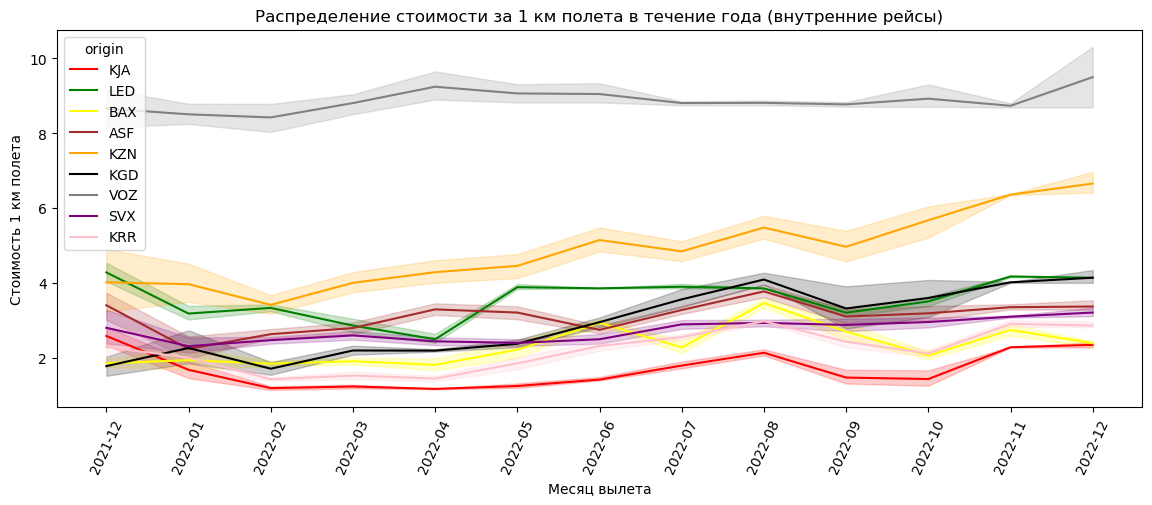

In [276]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from datetime import datetime, time
from matplotlib.pylab import rcParams

%matplotlib inline

plt.figure(figsize = (14, 5), dpi=100) 

sns.lineplot(x='depart_month', y='distance_unit_price', hue='origin', palette=['red'], data=kja_mow)
sns.lineplot(x='depart_month', y='distance_unit_price', hue='origin', palette=['green'], data=spb_mow)
sns.lineplot(x='depart_month', y='distance_unit_price', hue='origin', palette=['yellow'], data=bax_mow)
sns.lineplot(x='depart_month', y='distance_unit_price', hue='origin', palette=['brown'], data=asf_mow)
sns.lineplot(x='depart_month', y='distance_unit_price', hue='origin', palette=['orange'], data=kzn_mow)
sns.lineplot(x='depart_month', y='distance_unit_price', hue='origin', palette=['black'], data=kgd_mow)
sns.lineplot(x='depart_month', y='distance_unit_price', hue='origin', palette=['gray'], data=voz_mow)
sns.lineplot(x='depart_month', y='distance_unit_price', hue='origin', palette=['purple'], data=svx_mow)
sns.lineplot(x='depart_month', y='distance_unit_price', hue='origin', palette=['pink'], data=krr_mow)



plt.xticks(rotation=65)
plt.grid(True, linestyle="")
plt.title("Распределение стоимости за 1 км полета в течение года (внутренние рейсы)")
plt.xlabel("Месяц вылета")
plt.ylabel("Стоимость 1 км полета")
plt.show()

Рассматривая полученную выше зависимость, мы можем дать предварительную оценку одной из идей данного проекта. Определить каким образом меняется динамика цен на перелет в течние года для рейсов среди городов внутри России, а так же для ряда столиц зарубежных стран.
<br> На данной зависимости видим что первый пик рост цен приходится на лето, август месяц, затем идет некоторое снижение, после которого, начиная с сентября - октября, следует новый рост стоимости перелета за 1 км, который продолжается вплоть до конца года.

In [277]:
#Добавим выбранные наборы данных перелетов по направлениям внутри России в общий датасет:
flight_insight = pd.concat([kja_mow, spb_mow, bax_mow, asf_mow, kzn_mow, kgd_mow, voz_mow, svx_mow, krr_mow], axis=0, ignore_index=True)
flight_insight

,value,origin,destination,depart_date,number_of_changes,duration,distance,depart_month,distance_unit_price
0,8796.0,KJA,MOW,2021-12-22,1,2605,3337,2021-12,2.627240
1,10199.0,KJA,MOW,2021-12-23,1,505,3337,2021-12,3.070138
2,9752.0,KJA,MOW,2021-12-24,1,2605,3337,2021-12,2.912784
3,9565.0,KJA,MOW,2021-12-25,0,310,3337,2021-12,2.879290
4,6599.0,KJA,MOW,2021-12-26,0,320,3337,2021-12,1.971027
...,...,...,...,...,...,...,...,...,...
2854,3250.0,KRR,MOW,2022-12-10,0,135,1187,2022-12,2.808989
2855,3250.0,KRR,MOW,2022-12-11,0,135,1187,2022-12,2.808989
2856,4080.0,KRR,MOW,2022-12-12,0,135,1187,2022-12,3.526361
2857,3250.0,KRR,MOW,2022-12-13,0,135,1187,2022-12,2.808989


<Figure size 1400x500 with 0 Axes>

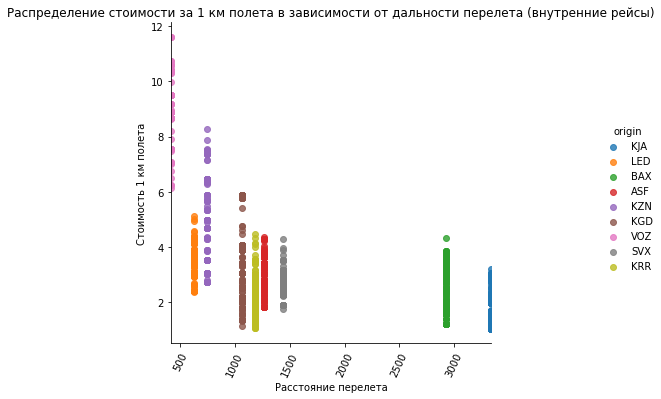

In [278]:
plt.figure(figsize = (14, 5), dpi=100) 

sns.lmplot(x='distance', y='distance_unit_price', hue='origin', data=flight_insight)

plt.xticks(rotation=65)
plt.grid(True, linestyle="")
plt.title("Распределение стоимости за 1 км полета в зависимости от дальности перелета (внутренние рейсы)")
plt.xlabel("Расстояние перелета")
plt.ylabel("Стоимость 1 км полета")
plt.show()

Исходя из представленной графической зависимости, для внутренних рейсов заметра динамика снижения стоимости 1 км перелета с увеличением дальности перелета. 

### 1.3.2 Динамика стоимости международных перелетов из России в течение года. 

<br> Оценим динамику изменения стоимости перелетов из Москвы в Вену, Анталию и Дубай в течение года.

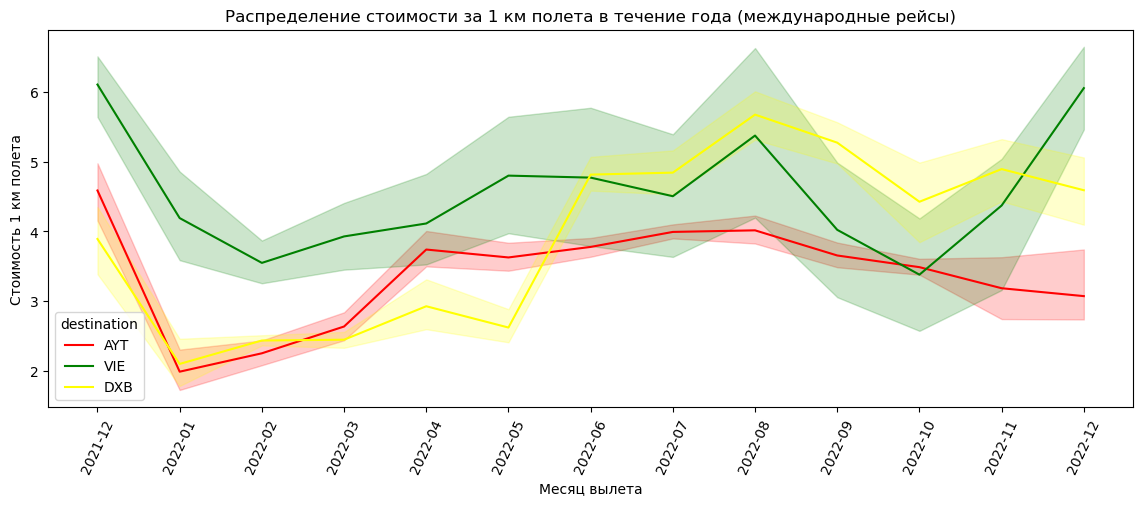

In [279]:
plt.figure(figsize = (14, 5), dpi=100) 

sns.lineplot(x='depart_month', y='distance_unit_price', hue='destination', palette=['red'], data=mow_ayt)
sns.lineplot(x='depart_month', y='distance_unit_price', hue='destination', palette=['green'], data=mow_vie)
sns.lineplot(x='depart_month', y='distance_unit_price', hue='destination', palette=['yellow'], data=mow_dxb)

plt.xticks(rotation=65)
plt.grid(True, linestyle="")
plt.title("Распределение стоимости за 1 км полета в течение года (международные рейсы)")
plt.xlabel("Месяц вылета")
plt.ylabel("Стоимость 1 км полета")
plt.show()

Для международных рейсов так же характерен спад стоимости за 1 км перелета в первые месяцы года. После чего следует рост стоимости с максимумом в летние месяцы, затем следует спад на сенятбрь-октябрь. Динамика стоимости перелета для Вены после сентября месяца отлична от динамики стоимости перелета для направлений Антальи и Дубая. В данном случае можно предположить и обосновать такое расхождение туристической активностью российских туристов в летние, отпускные, месяцы года.

In [280]:
#Добавим выбранные наборы данных перелетов по международным направлениям из Москвы в общий датасет:
flight_outsight = pd.concat([mow_ayt, mow_vie, mow_dxb], axis=0, ignore_index=True)
flight_outsight

,value,origin,destination,depart_date,number_of_changes,duration,distance,depart_month,distance_unit_price
0,11423.0,MOW,AYT,2021-12-21,1,1325,2129,2021-12,5.370475
1,8059.0,MOW,AYT,2021-12-22,1,1565,2129,2021-12,3.701883
2,8632.0,MOW,AYT,2021-12-23,0,230,2129,2021-12,4.041199
3,8894.0,MOW,AYT,2021-12-24,1,730,2129,2021-12,4.163858
4,7650.0,MOW,AYT,2021-12-25,0,225,2129,2021-12,3.596615
...,...,...,...,...,...,...,...,...,...
868,16800.0,MOW,DXB,2022-12-11,1,1075,3671,2022-12,4.528302
869,20044.0,MOW,DXB,2022-12-14,0,325,3671,2022-12,5.446739
870,20038.0,MOW,DXB,2022-12-16,0,325,3671,2022-12,5.445109
871,20800.0,MOW,DXB,2022-12-17,0,325,3671,2022-12,5.652174


Оценим зависимость стоимости 1 км перелета от расстояния перелета для международных рейсов:

<Figure size 1400x800 with 0 Axes>

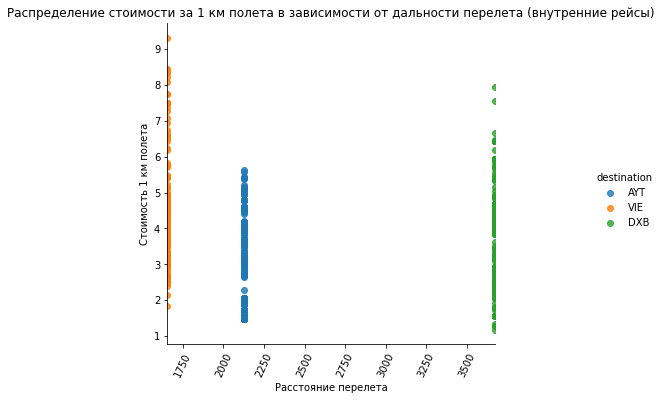

In [284]:
plt.figure(figsize = (14, 8), dpi=100) 

sns.lmplot(x='distance', y='distance_unit_price', hue='destination', data=flight_outsight)

plt.xticks(rotation=65)
plt.grid(True, linestyle="")
plt.title("Распределение стоимости за 1 км полета в зависимости от дальности перелета (внутренние рейсы)")
plt.xlabel("Расстояние перелета")
plt.ylabel("Стоимость 1 км полета")
plt.show()

Зависимость представленная на графике выше аналогична зависимости с внутренними рейсами по России. Стоимость 1 км перелется уменьшается с увеличением протяженности перелета. Однако ввиду ограниченного набора данных, данное утверждение необходимо рассценивать как предположение.

## 1.4 Моменты, которые позволяют до проведения расчетов и построения моделей, выдвинуть несколько гипотез/предположений о результатах следующих этапов и т.д.

Исходя из имеющихся данных, можно выдвинуть следующие гипотезы:
<br>1. С увеличением дальности перелета как для внутренних так и для международных рейсов, стоимость 1 км пути снижается.
<br> 2. Для внутренних рейсов, при перелете из крупных городов России в Москву: cтоимость билета имеет первый максимум к концу августа месяца, второй максимум к концу декабря.
<br> 3. Для международных рейсов, при перелете из Москвы в крупные города Европы и Ближнего Востока: стоимость билета так же имеет первый максимум к концу августа-сентярбя, второй максимум к концу декабря.

## ЧАСТЬ 2. Нахождение дешевого авиамаршрута. Применение алгоритма.

Задача состоит в том, чтобы реализовать дешевые маршруты. Наиболее удобно будет представить города в виде вершин взвешенного направленного графа: создадим граф, где вершина это город, ребро - это перелет, а вес ребра - это цена. И по нужному нам маршруту найти кратчайший путь, применив алгоритм обхода графа. Будем использовать алгоритм Дейкстры, так как он очень подходит для того чтобы искать кратчайшие расстояния во взвешенном графе.

In [1]:
import collections
from collections import deque
import matplotlib.pyplot as plt

Реализуем функцию add_edge для заполнения нашего графа.

In [2]:
def add_edge(G, a, b, weight):
    if a not in G:
        G[a] = {b:weight}
    else:
        G[a][b] = weight

Объединим списки с данными по всем городам, полученные через API в первой части

In [11]:
list_c = list_dates_1 + list_dates_2 + list_dates_3 + list_dates_4 + list_dates_5 + list_dates_6 + list_dates_7 + list_dates_8 + list_dates_9 + list_dates_10 + list_dates_11 + list_dates_12 + list_dates_13 + list_dates_14 + list_dates_15

Данный список будет использован ниже для поиска маршрутов по нужной дате.

Найдём полеты по дате 17-04-2022(ввод вводится как ГГГГ-ММ-ДД, напр. 2021-03-12):

In [12]:
date = input() # Вводится нужная дата полета
a = [] # задается список вершин графа, где ими будут выступать пункты вылета/прилета
b = [] # задается список вершин графа, где ими будут выступать пункты вылета/прилета
weight = [] # в данном списке будут хранится веса между вершинами(ребрами)
for i in range(len(list_c)):
    for k in range(len(list_c[i]['data'])): #поиск циклом внутри списка маршрутов с нужной датой и добавляется в соотв. список
        if date == list_c[i]['data'][k]['depart_date']:  
            a.append(list_c[i]['data'][k]['origin'])  
            b.append(list_c[i]['data'][k]['destination'])
            weight.append(list_c[i]['data'][k]['value'])

2022-04-17


Заполним граф полученными списками

In [13]:
G = {}
for i, j, k in zip(a, b, weight):
    add_edge(G, i, j, k)
    add_edge(G, j, i, k)

Граф заполнен и представлен ниже:

In [15]:
G

{'MOW': {'KJA': 3985,
  'LED': 1895,
  'BAX': 9458,
  'ASF': 3830,
  'KZN': 4260,
  'KGD': 2193,
  'ABA': 11162,
  'VOZ': 3554,
  'UUS': 14485,
  'SVX': 3299,
  'KRR': 2059,
  'AYT': 7553,
  'VIE': 7649,
  'DXB': 14250},
 'KJA': {'MOW': 3985,
  'LED': 5480,
  'ASF': 11378,
  'KZN': 11401,
  'KGD': 10398,
  'VOZ': 11825,
  'SVX': 17859,
  'KRR': 6030,
  'AYT': 19570,
  'DXB': 13368,
  'BAX': 15215,
  'ABA': 10560},
 'LED': {'MOW': 1895,
  'KJA': 5480,
  'BAX': 5978,
  'ASF': 4374,
  'KZN': 3735,
  'KGD': 2630,
  'ABA': 12910,
  'VOZ': 3599,
  'UUS': 27078,
  'SVX': 3649,
  'KRR': 2780,
  'AYT': 9004,
  'VIE': 14707,
  'DXB': 25348},
 'BAX': {'MOW': 9458,
  'LED': 5978,
  'KJA': 15215,
  'KZN': 11590,
  'KGD': 9591,
  'SVX': 7691,
  'KRR': 6487},
 'ASF': {'MOW': 3830,
  'KJA': 11378,
  'LED': 4374,
  'KGD': 9398,
  'KRR': 9248,
  'KZN': 8735,
  'VOZ': 10685},
 'KZN': {'MOW': 4260,
  'KJA': 11401,
  'LED': 3735,
  'BAX': 11590,
  'ASF': 8735,
  'KGD': 5275,
  'VOZ': 6447,
  'SVX': 5045,
 

Можем визуализировать полученный граф как ориентированный граф:

In [17]:
import networkx as nx

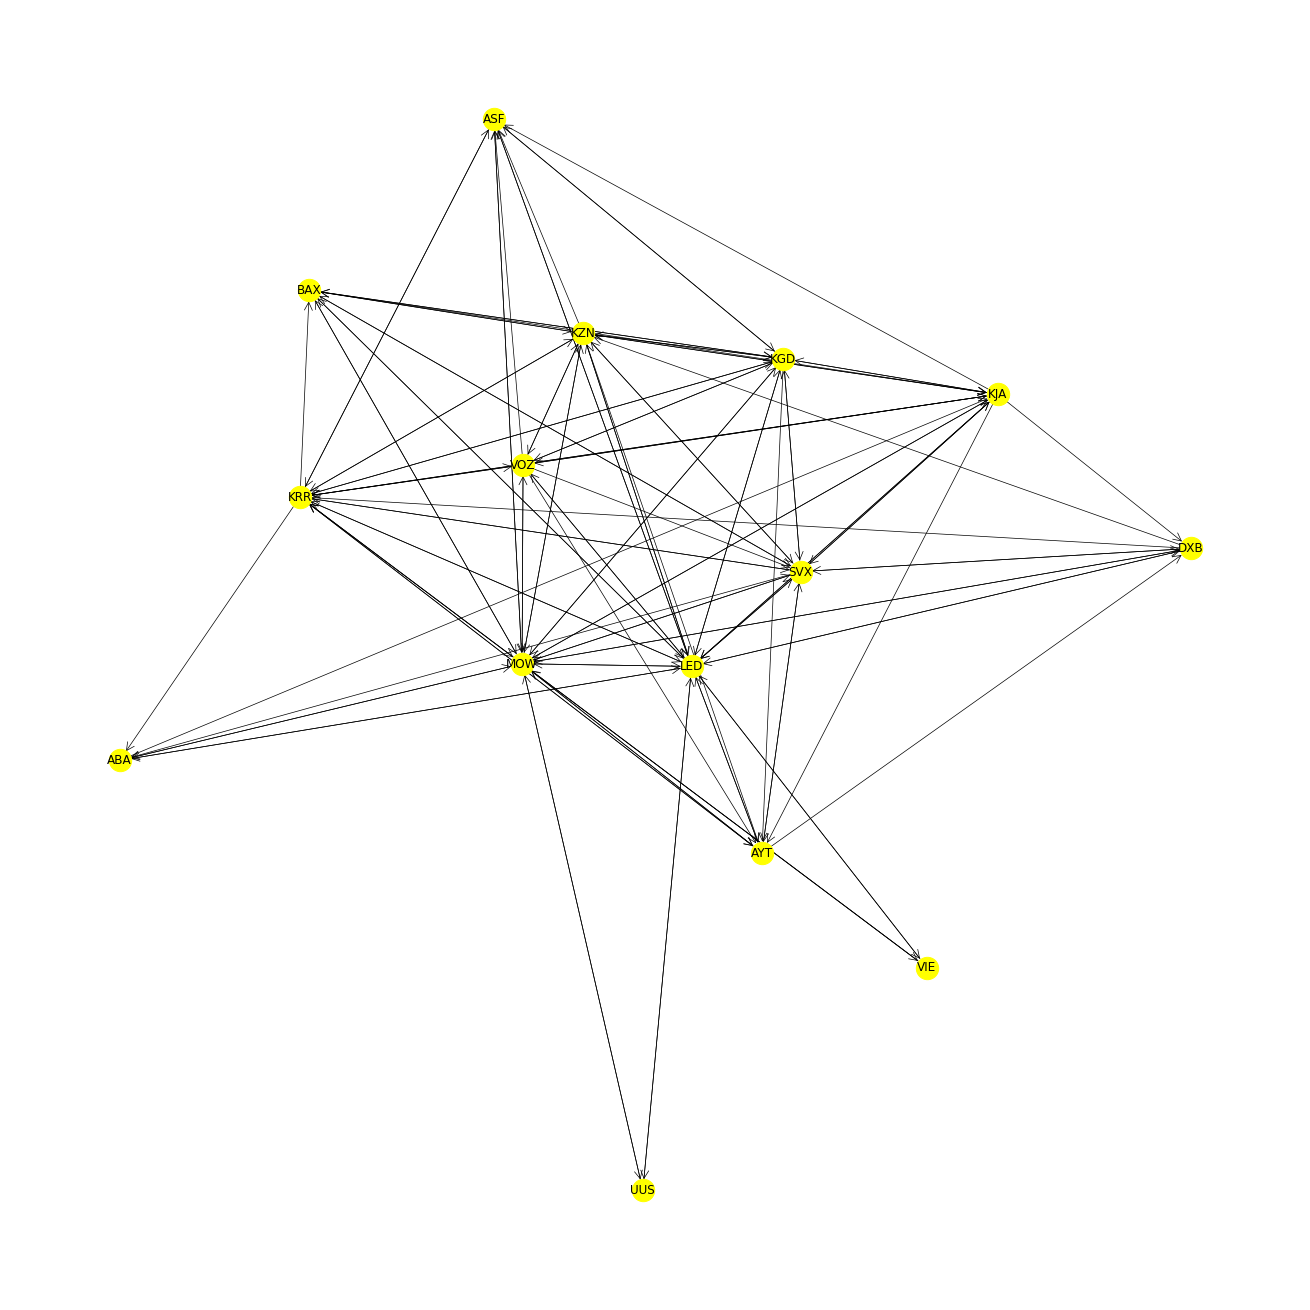

In [18]:
H = nx.DiGraph()
 
H.add_nodes_from(a)

for i, j in zip(a, b):
    H.add_edge(i, j)
pos = nx.spring_layout(H,k=0.15,iterations=20)
options = {
    'node_color': 'yellow',
    'node_size': 500,
    'width': 0.7,
    'arrowstyle': '->',
    'arrowsize': 20,
}
plt.figure(figsize=(18,18))
nx.draw(H, pos, with_labels=True, arrows=True, **options)
labels = nx.get_edge_attributes(H, 'weight')
plt.show()

Создаем функцию dijkstra_path, которая реализует алгоритм Дейкстры по собранному ранее графу и находит кратчайшие расстояния по весу(цена за полет), а на выходе выдает маршрут из IATA-кодов городов и наиболее дешевую цену по данному маршруту.

In [19]:
def dijkstra_path(G, start,end):
    Q = deque() # Q представляем как очередь
    s = {} # словарь расстояний графа
    p={start:None} # список "родителей" вершин
    s[start] = 0
    Q.append(start)
    while Q: # пока очередь не пуста
        v = Q.pop() # достаем элемент (вершину) из очереди
        for u in G[v]: # проходимся циклом по его соседям
            if u not in s or s[v]+G[v][u] < s[u]: #если вершина не в очереди или новое расстояние до нее меньше, чем изначальное
                s[u] = s[v] + G[v][u] # фиксируем это расстояние
                p[u] = v # фиксируем "родителя" в соответствующий список "вершин"
                Q.append(u) # добавляем соседей вершины в очередь для обработки

# Ниже реализуем фиксацию пути обхода графа по кратчайшему расстоянию
    path = [end]
    parent = p[end]
    while not parent is None:
        path.append(parent)
        parent = p[parent]
    print('Air route: ',end='')
    for i in path[::-1]:
        if i != path[0]:
            print(i,  '-> ', end='')
        else:
            print(i)
    
    for k in s:
        if k == end:
            print('Price:', s[end])

Применяя данную функцию находим наш наиболее дешевый маршрут по дате 17-04-2022

На вход подаем собранный граф, IATA-коды городов:хотим посмотреть наиболее дешевый маршрут из Красноярска в Вену.

In [20]:
dijkstra_path(G,'KJA', 'VIE')

Air route: KJA -> MOW -> VIE
Price: 11634


Видим, что наиболеее дешевый маршрут добраться 17-04-2022 из Красноярска в Вену через Москву по цене 11634 рубля.

## Вывод: обосновали, что наиболее подходящей реализацией авиамаршрута в  нашем случае будет представление его в виде графа. Соответсвенно, представили наш маршрут в виде ориентированного взвешенного графа: cогласно нужной дате извлекли все маршруты в этот день и собрали граф, где города-назначения - вершины, а вершины рёбер - перелет между этими городами, и цена перелета - вес. Такая модель нам позволила применить алгоритм Дейкстры для нахождения наиболее дешевого маршрута.